In [1]:
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import os
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import ProgressBar
from IPython.display import clear_output
from ignite.handlers import FastaiLRFinder
import matplotlib.pyplot as plt
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator

/SI/si/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
paths = []
labels = []
labels_categorical = []
root = 'SpeechDataset/'

# Iteracja przez katalogi w folderze głównym
for ind, subdir in enumerate(os.listdir(root)):
    subdir_path = os.path.join(root, subdir)
    if not os.path.isdir(subdir_path):
        continue
    for file in os.listdir(os.path.join(root, subdir))[:300]:
        filepath = os.path.join(root, subdir, file)
        if not filepath.endswith('.wav'):
            continue
        paths.append(filepath)
        labels.append(ind)
        labels_categorical.append(subdir)

print(f"Found {len(paths)} WAV files")

# Obliczanie cech logfbank dla każdego sygnału
logfbank_feats = []
for signal_path in paths:
    fs, sig = wav.read(signal_path)
    fbank_feat = logfbank(sig, samplerate=fs)
    logfbank_feats.append(fbank_feat)

# Ustalenie maksymalnej długości sygnału i wyrównanie długości
lengths = [i.shape[0] for i in logfbank_feats]
max_len = np.max(lengths)
print(f"Max length: {max_len}")

# Tworzenie macierzy o ustalonej maksymalnej długości
padded_feats = np.zeros((len(lengths), max_len, logfbank_feats[0].shape[1]), dtype=np.float32)
for i, feats in enumerate(logfbank_feats):
    padded_feats[i, :, :] = np.pad(feats, 
                                    ((int(np.floor((max_len - feats.shape[0]) / 2)),
                                      int(np.ceil((max_len - feats.shape[0]) / 2))),
                                     (0, 0)))

print(f"padded_feats shape: {padded_feats.shape}, dtype: {padded_feats.dtype}")

# Zapisanie wyników do plików
np.save('logfbank_feats.npy', padded_feats)
np.save('labels.npy', labels)
np.save('labels_categorical.npy', labels_categorical)


In [18]:
# Załadowanie danych
feats = np.load('t_logfbank_feats.npy')
labels = np.load('t_labels.npy')

# Przekształcenie danych
feats = feats.reshape(feats.shape[0], -1)
feats = feats.astype(np.float32)

# Podział na zbiory uczący, walidacyjny i testowy
X_train, X_val_test, y_train, y_val_test = train_test_split(    
    feats,
    labels,
    random_state=1,
    stratify=labels,
    train_size=0.8
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    random_state=1,
    stratify=y_val_test,
    train_size=0.5
)

In [19]:
trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
valset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
testset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [20]:
train_loader = DataLoader(trainset, batch_size=256)
val_loader = DataLoader(valset, batch_size=256)
test_loader = DataLoader(testset, batch_size=256)

In [21]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Pierwsza warstwa gęsta
        self.fc2 = nn.Linear(256, 128)   # Druga warstwa gęsta
        self.fc3 = nn.Linear(128, 64)   # Druga warstwa gęsta
        self.fc4 = nn.Linear(64, 42)    # Trzecia warstwa gęsta
        self.dropout1 = nn.Dropout(p = 0.5)  # Pierwsza warstwa dropout (50% prawdopodobieństwo wyłączenia neuronów)
        self.dropout2 = nn.Dropout(p = 0.35)  # Druga warstwa dropout (20% prawdopodobieństwo wyłączenia neuronów)
        self.dropout3 = nn.Dropout(p = 0.2)

    def forward(self, x):
        x = self.fc1(x)  # Przechodzimy przez pierwszą warstwę
        x = self.dropout1(x)  # Zastosowanie dropout po pierwszej warstwie
        x = self.fc2(x)  # Przechodzimy przez drugą warstwę
        x = self.dropout2(x)  # Zastosowanie dropout po drugiej warstwie
        x = self.fc3(x)  # Przechodzimy przez trzecią warstwę
        x = self.dropout3(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)  # Zastosowanie logarytmu softmax na wyjściu

device = "cuda" if torch.cuda.is_available() else "cpu"  # Sprawdza, czy dostępna jest karta graficzna (GPU), jeśli nie, używa CPU
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.NLLLoss()  # Definiuje funkcję strat (strata logarytmiczna z prawdopodobieństw)
# device='cpu'

i_s = X_train.shape[1]

model = Net(i_s)  # Inicjalizuje model sieci neuronowej
model.to(device)  # Przenosi model na odpowiednie urządzenie (GPU lub CPU)
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))  # Definiuje optymalizator SGD z określoną szybkością uczenia i momentem

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

# Tworzymy obiekt trenera
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

# Tworzymy obiekt ewaluatora
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.NLLLoss())}, 
                                         device=device)

# Dodajemy pasek postępu do trenera
ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

CUDA: True


In [82]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Changed activation function to ReLU
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.4148430066603235, 'loss': 2.1631758351421264}


In [32]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Changed activation function to ReLU
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.629757785467128, 'loss': 1.2777346706720372}


In [94]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.fc_feedback1 = nn.Linear(64, 256)  # Added feedback layer
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))  # Changed activation function to ReLU
        x1 = self.dropout1(x1)
        x2 = F.relu(self.fc2(x1))
        x2 = self.dropout2(x2)
        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout3(x3)
        x2_feedback = F.relu(self.fc_feedback1(x3)) 
        x2 = F.relu(self.fc2(x2_feedback+x1))
        x2 = self.dropout2(x2)
        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout3(x3)
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.5499524262607041, 'loss': 1.676873494737155}


In [58]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1+x2_temp))
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.relu(self.fc3(x2+x3_temp))
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6487889273356401, 'loss': 1.2243074727305905}


In [16]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.fc_feedback1 = nn.Linear(64, 256)  # Added feedback layer
        self.fc_feedback2 = nn.Linear(64, 128)  # Added feedback layer
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x1 = F.sigmoid(self.fc1(x))  # Changed activation function to ReLU
        x2 = F.sigmoid(self.fc2(x1))
        x2_temp = x2
        x3 = F.sigmoid(self.fc3(x2))
        x2_feedback = F.sigmoid(self.fc_feedback1(x3))
        x2 = F.sigmoid(self.fc2(x2_feedback+x1))
        x2 = self.dropout2(x2)
        x3 = F.sigmoid(self.fc3(x2+x2_temp))
        x3 = self.dropout3(x3)
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.2445290199809705, 'loss': 2.604614838546622}


In [17]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.fc_feedback1 = nn.Linear(64, 256)  # Added feedback layer
        self.fc_feedback2 = nn.Linear(64, 128)  # Added feedback layer
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x1 = F.tanh(self.fc1(x))  # Changed activation function to ReLU
        x2 = F.tanh(self.fc2(x1))
        x2_temp = x2
        x3 = F.tanh(self.fc3(x2))
        x2_feedback = F.tanh(self.fc_feedback1(x3))
        x2 = F.tanh(self.fc2(x2_feedback+x1))
        x2 = self.dropout2(x2)
        x3 = F.tanh(self.fc3(x2+x2_temp))
        x3 = self.dropout3(x3)
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.3082778306374881, 'loss': 2.3845277563035205}


In [63]:
@trainer.on(Events.EPOCH_COMPLETED)
# Walidacja ma być przeprowadzona po zakończeniu każdej epoki
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

# Trening modelu przez 150 epok
trainer.run(train_loader, max_epochs=100)

# Ewaluacja modelu na zbiorze testowym
evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.3558515699333968, 'loss': 2.3908607780536393}


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 1 Avg accuracy: 0.64 Avg loss: 1.28


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 2 Avg accuracy: 0.66 Avg loss: 1.25


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 3 Avg accuracy: 0.67 Avg loss: 1.25


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 4 Avg accuracy: 0.66 Avg loss: 1.26


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 5 Avg accuracy: 0.65 Avg loss: 1.27


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 6 Avg accuracy: 0.66 Avg loss: 1.30


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 7 Avg accuracy: 0.66 Avg loss: 1.28


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 8 Avg accuracy: 0.61 Avg loss: 1.39


[1/19]   5%|5          [00:00<?]

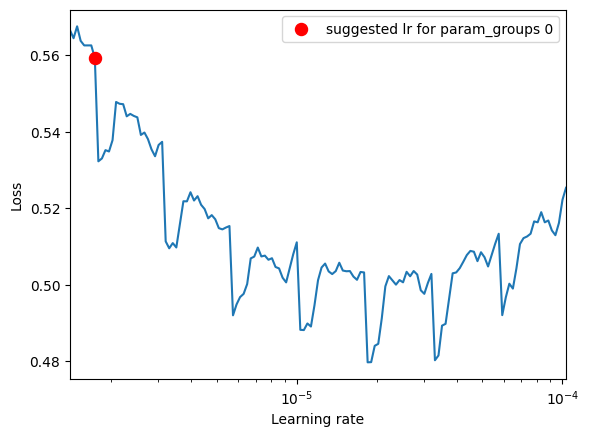

Suggested LR: 1.7378008287493753e-06


In [54]:
# Inicjalizacja obiektu FastaiLRFinder
lr_finder = FastaiLRFinder()

# Przygotowanie słownika z modelem i optymalizatorem
to_save = {'model': model, 'optimizer': optimizer}

# Dołączenie lr_finder do trenera i ustawienie wartości diverge_th na 1.1
with lr_finder.attach(trainer, to_save, diverge_th=1.1, start_lr=1e-6, end_lr=100.0, num_iter=600) as trainer_with_lr_finder:
    # Domyślnie start_lr jest taki, jak określono w obiekcie optimizer, 
    # a end_lr = 10
    trainer_with_lr_finder.run(train_loader)

# Pobranie wyników po zakończeniu poszukiwań najlepszego LR
results = lr_finder.get_results()

# Wykres przedstawiający wyniki
lr_finder.plot()

# Wyświetlenie sugerowanego współczynnika uczenia
print("Suggested LR:", lr_finder.lr_suggestion())


In [55]:
# Utworzenie obiektów trainer i evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    model,
    metrics={"acc": Accuracy(), "loss": Loss(nn.CrossEntropyLoss())},
    device=device
)

# Dodanie paska postępu do trenera
ProgressBar(persist=True).attach(
    trainer, output_transform=lambda x: {"batch loss": x}
)

# Funkcja walidacji po zakończeniu epoki
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)  # Przeprowadzenie walidacji
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch} "
          f"Avg accuracy: {metrics['acc']:.2f} "
          f"Avg loss: {metrics['loss']:.2f}")
    
    # Zastosowanie sugerowanego współczynnika uczenia
    lr_finder.apply_suggested_lr(optimizer)
    print(f'Training with suggested lr: {optimizer.param_groups[0]["lr"]}')

# Rozpoczęcie treningu
trainer.run(train_loader, max_epochs=50)

# Ewaluacja na zbiorze testowym
evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)


{'acc': 0.7076124567474048, 'loss': 1.0437319006474373}


In [ ]:
import numpy as np

def skok(x):
  if (x >= 0):
    return 1
  else:
    return 0

num_epochs = 10
alpha = 0.75

x = np.array([[0,0,0], [0,1,0], [1,0,0], [1,1,1]])
input_data = x[:, 0:2]
results_data = x[:, 2:]

x0 = np.ones(4)

print(input_data)
input_data = np.c_[x0, input_data]
print(input_data)

weights = np.random.uniform(0,1,3)

for i in range(num_epochs):
  print('EPOKA', i+1)
  for i in range(input_data.shape[0]):
    s = input_data[i].dot(weights)
    result = skok(s)

    if (result != results_data[i]):
      print('błąd')
      weights = weights - alpha * (result - results_data[i]) * input_data[i]
      print('nowe wagi:', weights)
    else:
      print('poprawnie')

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
from IPython.display import clear_output

class TransformerNet(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, num_decoder_layers):
        super(TransformerNet, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, batch_first=True)
        self.fc1 = nn.Linear(d_model, 128)
        self.fc2 = nn.Linear(128, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x, x)
        x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

input_size = X_train.shape[1]  # Example for sequence data
d_model = 128
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2
model = TransformerNet(input_size, d_model, nhead, num_encoder_layers, num_decoder_layers)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.028544243577545196, 'loss': nan}
